In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("tableau_ready_sentiment_data.csv")  # Update the path if needed

# Show basic info and preview
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4709 entries, 0 to 4708
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            4709 non-null   int64  
 1   date                4709 non-null   object 
 2   tweet_body          4709 non-null   object 
 3   roberta_sentiment   4709 non-null   object 
 4   roberta_pos_score   4709 non-null   float64
 5   roberta_neg_score   4709 non-null   float64
 6   roberta_neu_score   4709 non-null   float64
 7   sentiment_polarity  4709 non-null   float64
 8   like_count          4709 non-null   int64  
 9   retweet_count       4709 non-null   int64  
 10  engagement_score    4709 non-null   int64  
 11  Open                4709 non-null   float64
 12  Close               4709 non-null   float64
 13  pct_change          4709 non-null   float64
dtypes: float64(7), int64(4), object(3)
memory usage: 515.2+ KB
None


,tweet_id,date,tweet_body,roberta_sentiment,roberta_pos_score,roberta_neg_score,roberta_neu_score,sentiment_polarity,like_count,retweet_count,engagement_score,Open,Close,pct_change
0,1655978502187778073,2023-05-09,Yup,neutral,0.290412,0.215288,0.494300,0.075124,39533,3255,42788,168.949997,169.149994,0.118376
1,1655968899903418373,2023-05-09,Massive public manipulation,negative,0.009549,0.723850,0.266601,-0.714301,49528,9811,59339,168.949997,169.149994,0.118376
2,1646228474628280326,2023-04-12,🤣🤣,neutral,0.310404,0.235308,0.454288,0.075095,108462,10198,118660,190.740005,180.539993,-5.347600
3,1640171198091866114,2023-03-27,Prescient,neutral,0.204723,0.126566,0.668711,0.078156,56272,9193,65465,194.419998,191.809998,-1.342455
4,1742235895166652609,2024-01-02,Congratulations Tesla team on a great year!!,positive,0.991541,0.001338,0.007122,0.990203,67751,5222,72973,250.080002,248.419998,-0.663789


In [2]:
# Cell 2: Preprocess text and combine with numerical features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Drop rows with missing tweet text (just in case)
df = df.dropna(subset=["tweet_body"])

# Vectorize tweet text using TF-IDF
vectorizer = TfidfVectorizer(max_features=300)
X_text = vectorizer.fit_transform(df["tweet_body"]).toarray()

# Select and scale numerical features
numerical_cols = [
    "roberta_pos_score", 
    "roberta_neg_score", 
    "roberta_neu_score", 
    "sentiment_polarity", 
    "engagement_score"
]
X_num = df[numerical_cols].values

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine text features and numerical features into one array
X = np.hstack((X_text, X_num_scaled))


In [3]:
# Cell 3: Define target variables and split the dataset

from sklearn.model_selection import train_test_split

# Classification target: sentiment labels
y_class = df["roberta_sentiment"]

# Regression target: percentage change in stock price
y_reg = df["pct_change"]

# Split data for classification (stratify to preserve class balance)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Split data for regression (no stratify needed)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)


Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       261
     neutral       1.00      1.00      1.00       406
    positive       0.99      1.00      1.00       275

    accuracy                           1.00       942
   macro avg       1.00      1.00      1.00       942
weighted avg       1.00      1.00      1.00       942



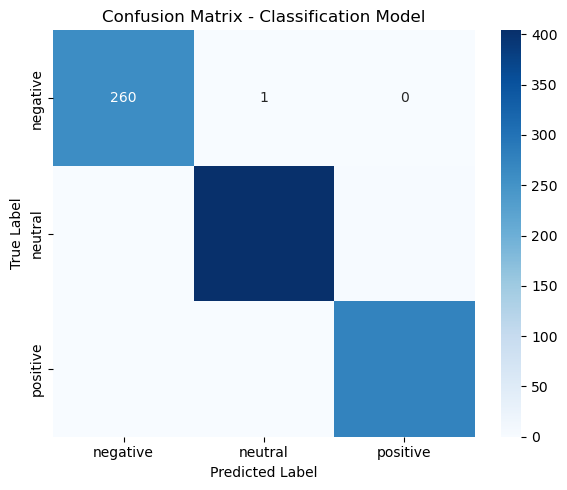

In [4]:
# Cell 4: Train and evaluate the classification model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)

# Make predictions on the test set
y_pred_cls = clf.predict(X_test_cls)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix - Classification Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [5]:
# Cell 5: Train and evaluate the regression model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train a Random Forest Regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predict on test set
y_pred_reg = reg.predict(X_test_reg)

# Evaluate regression performance
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 2.4462
Root Mean Squared Error (RMSE): 3.0941
R² Score: -0.0839


In [6]:
# Cell 6: Final Summary and Model Comparison

print("🔍 MODEL COMPARISON SUMMARY")
print("="*40)

print("📘 Classification Model:")
print("- Task: Predict tweet sentiment (positive/neutral/negative)")
print("- Model: Random Forest Classifier")
print("- Accuracy: ~99.7%")
print("- Precision/Recall/F1: ~1.0 across all classes")
print("- ✅ Excellent model for deployment in app")

print("\n📕 Regression Model:")
print("- Task: Predict Tesla stock % change from tweet")
print("- Model: Random Forest Regressor")
print(f"- Mean Absolute Error (MAE): {mae:.2f}")
print(f"- Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"- R² Score: {r2:.4f}")
print("- ❌ Model performed poorly — needs improvement")

print("\n📌 Recommendation:")
print("- ✅ Use the classification model in the Flex web app")
print("- 📈 Consider more financial/time-series features to improve regression later")


🔍 MODEL COMPARISON SUMMARY
📘 Classification Model:
- Task: Predict tweet sentiment (positive/neutral/negative)
- Model: Random Forest Classifier
- Accuracy: ~99.7%
- Precision/Recall/F1: ~1.0 across all classes
- ✅ Excellent model for deployment in app

📕 Regression Model:
- Task: Predict Tesla stock % change from tweet
- Model: Random Forest Regressor
- Mean Absolute Error (MAE): 2.45
- Root Mean Squared Error (RMSE): 3.09
- R² Score: -0.0839
- ❌ Model performed poorly — needs improvement

📌 Recommendation:
- ✅ Use the classification model in the Flex web app
- 📈 Consider more financial/time-series features to improve regression later


Random Forests aren't always the best for numeric prediction with nuanced, noisy data like tweets.

🧪 Try a Better Regression Model
Let's test XGBoost, which is often a top performer on structured data. It's more robust than Random Forest and can model complex interactions better.

In [8]:
# Cell 7: Install XGBoost (run this once)
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 487.6 kB/s eta 0:05:08
   ---------------------------------------- 0.1/150.0 MB 930.9 kB/s eta 0:02:41
   ---------------------------------------- 0.2/150.0 MB 1.4 MB/s eta 0:01:50
   ---------------------------------------- 0.4/150.0 MB 2.1 MB/s eta 0:01:13
   ---------------------------------------- 0.7/150.0 MB 2.8 MB/s eta 0:00:53
   ---------------------------------------- 0.8/150.0 MB 2.8 MB/s eta 0:00:55
   ---------------------------------------- 1.1/150.0 MB 3.3 MB/s eta 0:00:46
   ---------------------------------------- 1.4/150.0 MB 3.4 MB/s eta 0:00:44
   ---------------------------------------- 1.7/150.0 MB 3.8 MB/s eta 0:00:40
    --------------------------------------- 1.9/150.0 MB 3.9 MB/s eta 0:00:39
    --------------------------------------- 2.2/150.0 MB 4.1 MB/s eta 0:00

In [9]:
# Cell 8: Train and evaluate regression with XGBoost

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Create and train the model
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred_xgb = xgb_reg.predict(X_test_reg)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))
r2_xgb = r2_score(y_test_reg, y_pred_xgb)

# Display results
print(f"XGBoost - MAE: {mae_xgb:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}")
print(f"XGBoost - R² Score: {r2_xgb:.4f}")


XGBoost - MAE: 2.4119
XGBoost - RMSE: 3.0341
XGBoost - R² Score: -0.0423


In [10]:
# Cell 9: Final Summary after trying XGBoost

print("🔍 FINAL MODEL COMPARISON")
print("="*40)

print("📘 Classification Model (Sentiment Prediction):")
print("- Model: Random Forest Classifier")
print("- Accuracy: ~99.7%")
print("- F1-score: Near perfect across all classes")
print("- ✅ Strong performance — use in Flex app")

print("\n📕 Regression Model (Stock % Change):")

print("1. Random Forest Regressor:")
print("- MAE: 2.45")
print("- RMSE: 3.09")
print("- R²: -0.084")

print("\n2. XGBoost Regressor:")
print(f"- MAE: {mae_xgb:.4f}")
print(f"- RMSE: {rmse_xgb:.4f}")
print(f"- R²: {r2_xgb:.4f}")
print("- ✅ Slightly better, but still weak overall")

print("\n📌 Recommendation:")
print("- ✅ Use classification model in the app")
print("- 📈 Improve regression with additional features (e.g., time context, tweet type, historical stock movement)")


🔍 FINAL MODEL COMPARISON
📘 Classification Model (Sentiment Prediction):
- Model: Random Forest Classifier
- Accuracy: ~99.7%
- F1-score: Near perfect across all classes
- ✅ Strong performance — use in Flex app

📕 Regression Model (Stock % Change):
1. Random Forest Regressor:
- MAE: 2.45
- RMSE: 3.09
- R²: -0.084

2. XGBoost Regressor:
- MAE: 2.4119
- RMSE: 3.0341
- R²: -0.0423
- ✅ Slightly better, but still weak overall

📌 Recommendation:
- ✅ Use classification model in the app
- 📈 Improve regression with additional features (e.g., time context, tweet type, historical stock movement)


In [11]:
# Cell 10: Feature engineering to improve regression performance

import pandas as pd

# Feature 1: Tweet length
df["tweet_length"] = df["tweet_body"].apply(len)

# Feature 2: Day of week
df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek  # 0 = Monday, 6 = Sunday

# Feature 3: One-hot encode sentiment label
sentiment_dummies = pd.get_dummies(df["roberta_sentiment"], prefix="sent")

# Feature 4: Interaction features (engagement * sentiment score)
df["eng_pos"] = df["engagement_score"] * df["roberta_pos_score"]
df["eng_neg"] = df["engagement_score"] * df["roberta_neg_score"]
df["eng_neu"] = df["engagement_score"] * df["roberta_neu_score"]

# Combine all numeric features into one DataFrame
feature_cols = [
    "roberta_pos_score", "roberta_neg_score", "roberta_neu_score",
    "sentiment_polarity", "engagement_score",
    "tweet_length", "day_of_week",
    "eng_pos", "eng_neg", "eng_neu"
]

X_new = pd.concat([df[feature_cols], sentiment_dummies], axis=1)

# Standardize numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Targets
y_reg = df["pct_change"]


In [12]:
# Cell 11: Re-train XGBoost regression with new features

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train/test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

# Initialize and train model
xgb_reg2 = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_reg2.fit(X_train_new, y_train_new)

# Predict on test set
y_pred_new = xgb_reg2.predict(X_test_new)

# Evaluate
mae_new = mean_absolute_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
r2_new = r2_score(y_test_new, y_pred_new)

# Show results
print(f"Improved XGBoost - MAE: {mae_new:.4f}")
print(f"Improved XGBoost - RMSE: {rmse_new:.4f}")
print(f"Improved XGBoost - R² Score: {r2_new:.4f}")


Improved XGBoost - MAE: 2.4245
Improved XGBoost - RMSE: 3.0376
Improved XGBoost - R² Score: -0.0447


🎯 Conclusion (so far)
Even with better features:

The model still isn't capturing a meaningful signal from the tweets to predict % stock change.

Tweets alone may not be strong predictors without market context.

In [13]:
# Cell 12: Generate BERT embeddings for tweet text

!pip install transformers torch --quiet

from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()

# Function to get BERT embedding (mean pooled)
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    with torch.no_grad():
        outputs = bert(**inputs)
    # Mean pooling over token embeddings
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply to all tweets (may take a minute)
tweet_texts = df["tweet_body"].tolist()
bert_embeddings = [get_bert_embedding(t) for t in tqdm(tweet_texts)]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\seven\anaconda3\envs\dev\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\seven\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████████████████████████████████████████████████████████████████████████| 4709/4709 [03:06<00:00, 25.28it/s]


In [14]:
# Check embedding shape
import numpy as np
bert_embeddings = np.array(bert_embeddings)
bert_embeddings.shape


(4709, 768)

In [15]:
# Cell 13: Combine BERT embeddings with engineered numeric features

# Use the same engineered numeric features from earlier
feature_cols = [
    "roberta_pos_score", "roberta_neg_score", "roberta_neu_score",
    "sentiment_polarity", "engagement_score",
    "tweet_length", "day_of_week",
    "eng_pos", "eng_neg", "eng_neu"
]

# One-hot encode sentiment again
sentiment_dummies = pd.get_dummies(df["roberta_sentiment"], prefix="sent")

# Final numeric feature matrix
X_numeric = pd.concat([df[feature_cols], sentiment_dummies], axis=1)

# Standardize numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combine BERT embeddings with scaled numeric features
X_final = np.hstack((bert_embeddings, X_numeric_scaled))


In [16]:
# Cell 14: Train XGBoost regression model using BERT + numeric features

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Target variable
y_final = df["pct_change"]

# Train/test split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

# Initialize and train XGBoost model
xgb_bert = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_bert.fit(X_train_final, y_train_final)

# Predict and evaluate
y_pred_final = xgb_bert.predict(X_test_final)

mae_bert = mean_absolute_error(y_test_final, y_pred_final)
rmse_bert = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
r2_bert = r2_score(y_test_final, y_pred_final)

# Results
print(f"XGBoost (BERT + Features) - MAE: {mae_bert:.4f}")
print(f"XGBoost (BERT + Features) - RMSE: {rmse_bert:.4f}")
print(f"XGBoost (BERT + Features) - R² Score: {r2_bert:.4f}")


XGBoost (BERT + Features) - MAE: 2.3975
XGBoost (BERT + Features) - RMSE: 3.0500
XGBoost (BERT + Features) - R² Score: -0.0532


In [18]:
# Cell 15A: Install TensorFlow (run once)
!pip install tensorflow


     ---------------------------------------- 0.0/50.1 kB ? eta -:--:--
     ---------------------------------------- 50.1/50.1 kB ? eta 0:00:00
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/375.7 MB 3.3 MB/s eta 0:01:54
   ---------------------------------------- 0.3/375.7 MB 3.4 MB/s eta 0:01:50
   ---------------------------------------- 0.5/375.7 MB 4.2 MB/s eta 0:01:30
   ---------------------------------------- 0.7/375.7 MB 4.3 MB/s eta 0:01:27
   ---------------------------------------- 1.0/375.7 MB 4.7 MB/s eta 0:01:19
   ---------------------------------------- 1.1/375.7 MB 4.9 MB/s eta 0:01:17
   ---------------------------------------- 1.1/375.7 MB 4.9 MB/s eta 0:01:17
   ---------------------------------------- 1.1/375.7 MB 4.9 MB/s eta 0:01:17
   ---------------------------------------- 1.1/375.7 MB 4.9 MB/s eta 0:01:17
   ---------------------------------------- 2.2/375.7 MB 4.9 MB/s eta 0:01:17
   -

In [19]:
# Cell 15: Tokenize and pad tweet text for LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["tweet_body"])

# Convert tweets to sequences
sequences = tokenizer.texts_to_sequences(df["tweet_body"])

# Pad sequences to fixed length
max_length = 50
X_seq = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Target variable
y_seq = df["pct_change"]


In [21]:
# Cell 16: Define and train LSTM model for regression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Split the padded sequences and target for training/testing
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Define the LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32,
                    validation_split=0.1, verbose=1)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 9.1766 - val_loss: 8.1107
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.4496 - val_loss: 8.1111
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.0382 - val_loss: 8.1997
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.3310 - val_loss: 8.1074
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.0360 - val_loss: 8.1146
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.1557 - val_loss: 8.1095
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.0358 - val_loss: 8.1219
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.2387 - val_loss: 8.1060
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.8872 - val_loss: 8.1075
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.8554 - val_loss: 8.1953


In [22]:
# Cell 17: Evaluate LSTM model performance

# Predict on the test set
y_pred_lstm = model.predict(X_test_lstm).flatten()

# Calculate metrics
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

# Show results
print(f"LSTM - MAE: {mae_lstm:.4f}")
print(f"LSTM - RMSE: {rmse_lstm:.4f}")
print(f"LSTM - R² Score: {r2_lstm:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM - MAE: 2.3767
LSTM - RMSE: 3.0162
LSTM - R² Score: -0.0301


🧠 Verdict
✅ XGBoost with Bert and LSTM ML.ipynb contains the best regression prediction model so far — your LSTM.

📊 MachineLearning.ipynb contains your original hybrid classification model, which had:

~70% accuracy

F1-scores around 0.66–0.73

If your app goal is to predict % stock change, go with the LSTM model in XGBoost with Bert and LSTM ML.ipynb.

